# 3.7: 神经网络-量子线路混合编程

## Hybrid Network

In [1]:
# |default_exp networks.hybrid
# |export
import torch
from torch import nn
from tensor_network.networks.adqc import ADQCNet, probabilities_adqc_classifier
from typing import Literal
from tensor_network.feature_mapping import cossin_feature_map, feature_map_to_qubit_state
from torch.nn import functional as F

In [2]:
# |export


class FCADQCHybridClassifier(nn.Module):
    """
    A hybrid classifier that combines a fully connected layer with an ADQC network.
    """

    def __init__(
        self,
        feature_num: int,
        dim_mid: int,
        class_num: int,
        num_qubits: int,
        num_adqc_layers: int,
        adqc_gate_pattern: Literal["brick", "stair"],
        identity_init: bool = False,
        double_precision: bool = False,
        feature_map: Literal["cossin"] = "cossin",
    ):
        """
        A hybrid classifier that combines a fully connected layer with an ADQC network.

        Args:
            feature_num (int): The number of features in the input data.
            dim_mid (int): The dimension of the middle layer of the fully connected network.
            class_num (int): The number of classes in the output.
            num_qubits (int): The number of qubits in the ADQC network.
            num_adqc_layers (int): The number of layers in the ADQC network.
            adqc_gate_pattern (str): The pattern of the ADQC network.
            identity_init (bool): Whether to use identity initialization for the ADQC network.
            double_precision (bool): Whether to use double precision for the ADQC network.
            feature_map (str): The feature map to use for the input data.
        """
        super().__init__()
        self.adqc_net = ADQCNet(
            num_qubits=num_qubits,
            num_layers=num_adqc_layers,
            gate_pattern=adqc_gate_pattern,
            identity_init=identity_init,
            double_precision=double_precision,
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(feature_num, dim_mid),
            nn.ReLU(),
            nn.Linear(dim_mid, num_qubits),
            nn.Tanh(),
        )
        self.feature_num = feature_num
        self.class_num = class_num
        if feature_map == "cossin":
            self.feature_map = cossin_feature_map
            self.feature_map_compiled = torch.compile(self.feature_map)
            self.feature_map_kwargs = {"theta": 0.5}
        else:
            raise Exception(f"The only implemented feature map is cossin, but got {feature_map}")

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        assert data.ndim == 2 and data.shape[1] == self.feature_num, (
            f"The input data must be a 2D tensor with the shape of (batch_size, {self.feature_num}), but got {data.shape}"
        )
        is_mps = data.device.type == "mps"
        feature_map = self.feature_map if is_mps else self.feature_map_compiled
        x = self.fc_layer(data)  # (batch_size, num_qubits)
        x = feature_map(x, **self.feature_map_kwargs)  # (batch_size, num_qubits, 2)
        state = feature_map_to_qubit_state(x)  # (batch_size, *qubit_dims)
        state = self.adqc_net(state)  # (batch_size, *qubit_dims)
        classes_probabilities = probabilities_adqc_classifier(
            state, self.class_num, fast_mode=not is_mps
        )  # (batch_size, num_classes)
        return classes_probabilities

## Training

### Hyperparameters

In [3]:
lr = 1e-3
batch_size = 200
num_epochs = 300
default_device = torch.device("cpu")


# Network parameters
num_qubits = 5
dim_mid = 100
adqc_net_depth = 4
adqc_net_gate_pattern = "stair"
adqc_net_identity_init = True
adqc_net_double_precision = False

# Data parameters
num_classes = 10
feature_dim = 784

### Dataset

In [4]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
cwd = os.getcwd()
dataset_cache_path = os.path.join(cwd, "datasets")

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.1307,), (0.3081,)
        ),  # normalization, see https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
    ]
)

mnist_train_set = datasets.MNIST(
    root=dataset_cache_path, train=True, download=True, transform=transform
)
mnist_test_set = datasets.MNIST(
    root=dataset_cache_path, train=False, download=True, transform=transform
)

train_loader = DataLoader(mnist_train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test_set, batch_size=batch_size, shuffle=False)

### Train

In [7]:
from tqdm.auto import tqdm
from torch.optim import Adam
from tensor_network.networks.adqc import calc_accuracy

In [8]:
model = FCADQCHybridClassifier(
    feature_num=feature_dim,
    dim_mid=dim_mid,
    class_num=num_classes,
    num_qubits=num_qubits,
    num_adqc_layers=adqc_net_depth,
    adqc_gate_pattern=adqc_net_gate_pattern,
).to(default_device)

optimizer = Adam(model.parameters(), lr=lr)

In [9]:
epoch_losses = torch.empty(num_epochs)
epoch_accuracies = torch.empty(num_epochs)

for epoch in tqdm(range(num_epochs)):
    batch_losses = []
    sample_count = 0
    correct_count = 0
    for data, target in train_loader:
        data, target = data.to(default_device), target.to(default_device)
        batch_num = data.shape[0]
        data = data.reshape(batch_num, -1)
        classes_probabilities = model(data)
        loss = F.nll_loss(torch.log(classes_probabilities), target)
        batch_losses.append(loss.detach().cpu() * batch_num)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        sample_count += batch_num
        correct_count += calc_accuracy(classes_probabilities, target) * batch_num

    epoch_loss = torch.tensor(batch_losses).sum() / sample_count
    epoch_accuracy = correct_count / sample_count
    epoch_losses[epoch] = epoch_loss
    epoch_accuracies[epoch] = epoch_accuracy

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
test_correct_count = []
test_sample_count = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(default_device), target.to(default_device)
        batch_num = data.shape[0]
        data = data.reshape(batch_num, -1)
        classes_probabilities = model(data)
        test_correct_count.append(calc_accuracy(classes_probabilities, target) * batch_num)
        test_sample_count += batch_num

test_accuracy = torch.tensor(test_correct_count).sum() / test_sample_count
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9420


/var/folders/cg/6l5b95y14c18297sgdjvpcbc0000gn/T/ipykernel_8827/3684262490.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


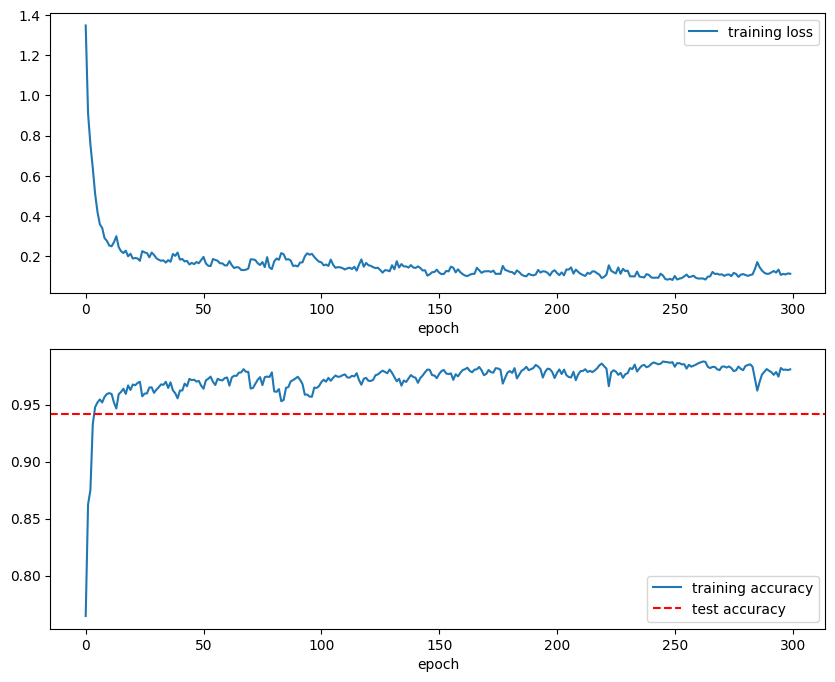

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(epoch_losses, label="training loss")
ax1.set_xlabel("epoch")
ax1.legend()
# plot training accuracy and test accuracy
ax2.plot(epoch_accuracies, label="training accuracy")
ax2.set_xlabel("epoch")
ax2.legend()
ax2.axhline(test_accuracy, label="test accuracy", color="red", linestyle="--")
ax2.legend()
fig.show()